In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet
from sklearn.model_selection import train_test_split

2023-04-25 00:49:36.149723: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
import cactas as C

In [4]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [5]:
images = np.load(images_file)
labels = np.load(labels_file)

In [6]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [7]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [8]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

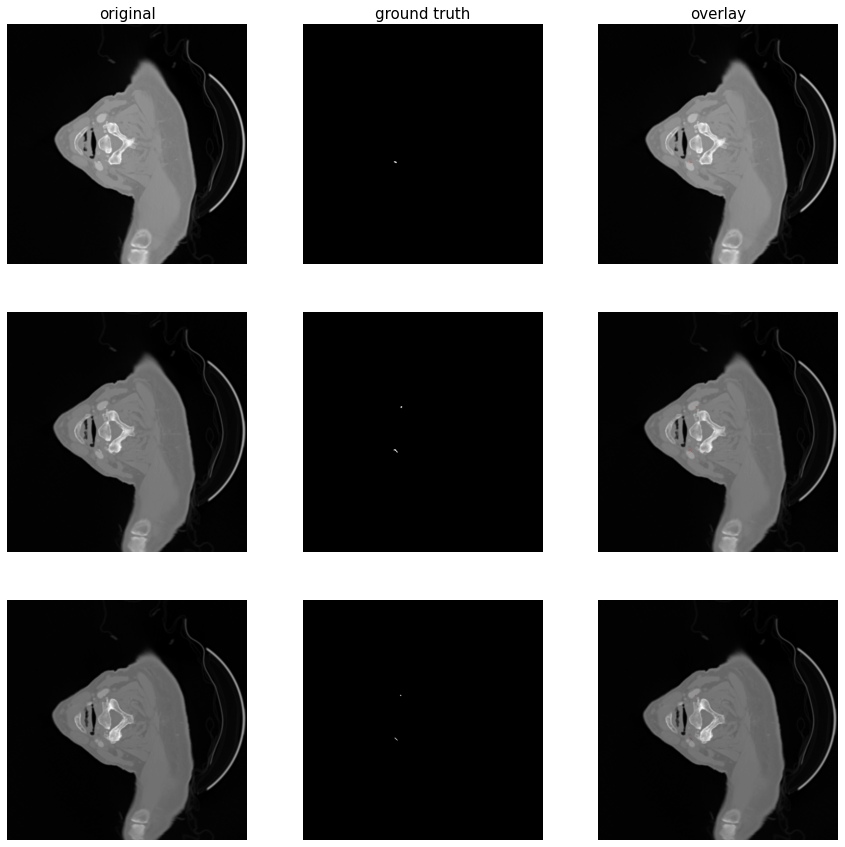

In [9]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = C.Util.split_1(images, labels, val_size=0.2)

In [12]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-04-25 00:49:40.234007: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-25 00:49:40.417770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 00:49:40.421770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-25 00:49:40.421789: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-25 00:49:40.421825: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-25 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [13]:
from tensorflow.keras import optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr = 0.001),
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-04-25 00:49:45.875245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-25 00:49:45.893180: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-04-25 00:50:10.744988: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-04-25 00:50:11.658216: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-04-25 00:50:11.658594: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-25 00:50:11.829453: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-04-25 00:50:11.994712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-04-25 00:50:12.539638: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-04-25 00:50:12.539662: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-04-25 00:50:12.53972

39/39 [==============================] - 62s 884ms/step - loss: 0.0528 - iou: 9.5808e-04 - iou_thresholded: 0.0014 - val_loss: 0.0051 - val_iou: 0.0025 - val_iou_thresholded: 0.0034
Epoch 2/200
39/39 [==============================] - 29s 756ms/step - loss: 0.0030 - iou: 0.0011 - iou_thresholded: 0.0015 - val_loss: 0.0038 - val_iou: 0.0020 - val_iou_thresholded: 0.0034
Epoch 3/200
39/39 [==============================] - 29s 758ms/step - loss: 0.0021 - iou: 0.0013 - iou_thresholded: 0.0015 - val_loss: 0.0025 - val_iou: 0.0016 - val_iou_thresholded: 0.0034
Epoch 4/200
39/39 [==============================] - 29s 755ms/step - loss: 0.0016 - iou: 0.0015 - iou_thresholded: 0.0015 - val_loss: 0.0028 - val_iou: 0.0027 - val_iou_thresholded: 0.0034
Epoch 5/200
39/39 [==============================] - 29s 757ms/step - loss: 0.0014 - iou: 0.0018 - iou_thresholded: 0.0015 - val_loss: 0.0028 - val_iou: 0.0031 - val_iou_thresholded: 0.0034
Epoch 6/200
39/39 [==============================] - 29s 7

39/39 [==============================] - 29s 753ms/step - loss: 1.9401e-04 - iou: 0.4756 - iou_thresholded: 0.5901 - val_loss: 0.0028 - val_iou: 0.0227 - val_iou_thresholded: 0.0170
Epoch 44/200
39/39 [==============================] - 29s 756ms/step - loss: 1.8416e-04 - iou: 0.4928 - iou_thresholded: 0.6143 - val_loss: 0.0030 - val_iou: 0.0191 - val_iou_thresholded: 0.0124
Epoch 45/200
39/39 [==============================] - 29s 757ms/step - loss: 1.7453e-04 - iou: 0.5064 - iou_thresholded: 0.6292 - val_loss: 0.0029 - val_iou: 0.0153 - val_iou_thresholded: 0.0084
Epoch 46/200
39/39 [==============================] - 30s 763ms/step - loss: 1.7270e-04 - iou: 0.5151 - iou_thresholded: 0.6379 - val_loss: 0.0029 - val_iou: 0.0180 - val_iou_thresholded: 0.0124
Epoch 47/200
39/39 [==============================] - 29s 748ms/step - loss: 1.6540e-04 - iou: 0.5279 - iou_thresholded: 0.6474 - val_loss: 0.0029 - val_iou: 0.0218 - val_iou_thresholded: 0.0169
Epoch 48/200
39/39 [==================

39/39 [==============================] - 30s 757ms/step - loss: 6.1208e-05 - iou: 0.7855 - iou_thresholded: 0.8705 - val_loss: 0.0036 - val_iou: 0.0300 - val_iou_thresholded: 0.0285
Epoch 86/200
39/39 [==============================] - 29s 753ms/step - loss: 6.3632e-05 - iou: 0.7829 - iou_thresholded: 0.8689 - val_loss: 0.0037 - val_iou: 0.0228 - val_iou_thresholded: 0.0217
Epoch 87/200
39/39 [==============================] - 30s 758ms/step - loss: 7.6493e-05 - iou: 0.7585 - iou_thresholded: 0.8380 - val_loss: 0.0035 - val_iou: 0.0226 - val_iou_thresholded: 0.0209
Epoch 88/200
39/39 [==============================] - 29s 747ms/step - loss: 8.5103e-05 - iou: 0.7347 - iou_thresholded: 0.8129 - val_loss: 0.0037 - val_iou: 0.0210 - val_iou_thresholded: 0.0187
Epoch 89/200
39/39 [==============================] - 30s 759ms/step - loss: 8.6926e-05 - iou: 0.7365 - iou_thresholded: 0.8139 - val_loss: 0.0035 - val_iou: 0.0259 - val_iou_thresholded: 0.0249
Epoch 90/200
39/39 [==================

Epoch 127/200
39/39 [==============================] - 29s 757ms/step - loss: 727.0588 - iou: 0.0016 - iou_thresholded: 0.0016 - val_loss: 461.6491 - val_iou: 0.0029 - val_iou_thresholded: 0.0029
Epoch 128/200
39/39 [==============================] - 30s 760ms/step - loss: 452.7905 - iou: 0.0018 - iou_thresholded: 0.0018 - val_loss: 471.9285 - val_iou: 0.0025 - val_iou_thresholded: 0.0025
Epoch 129/200
39/39 [==============================] - 30s 756ms/step - loss: 5654.2534 - iou: 0.0011 - iou_thresholded: 0.0011 - val_loss: 11202.5957 - val_iou: 0.0010 - val_iou_thresholded: 0.0010
Epoch 130/200
39/39 [==============================] - 29s 751ms/step - loss: 4880.7271 - iou: 8.6838e-04 - iou_thresholded: 8.6838e-04 - val_loss: 3252.3413 - val_iou: 9.7021e-04 - val_iou_thresholded: 9.7021e-04
Epoch 131/200
39/39 [==============================] - 29s 756ms/step - loss: 1989.8613 - iou: 9.6084e-04 - iou_thresholded: 9.6084e-04 - val_loss: 2063.8918 - val_iou: 0.0029 - val_iou_threshold

Epoch 169/200
39/39 [==============================] - 29s 749ms/step - loss: 116.3491 - iou: 0.0032 - iou_thresholded: 0.0032 - val_loss: 151.4859 - val_iou: 0.0044 - val_iou_thresholded: 0.0044
Epoch 170/200
39/39 [==============================] - 30s 757ms/step - loss: 127.7392 - iou: 0.0037 - iou_thresholded: 0.0037 - val_loss: 164.3629 - val_iou: 0.0030 - val_iou_thresholded: 0.0030
Epoch 171/200
39/39 [==============================] - 29s 757ms/step - loss: 87.6896 - iou: 0.0030 - iou_thresholded: 0.0030 - val_loss: 99.8670 - val_iou: 0.0020 - val_iou_thresholded: 0.0020
Epoch 172/200
39/39 [==============================] - 29s 758ms/step - loss: 157.3801 - iou: 0.0025 - iou_thresholded: 0.0025 - val_loss: 136.9307 - val_iou: 0.0035 - val_iou_thresholded: 0.0035
Epoch 173/200
39/39 [==============================] - 29s 758ms/step - loss: 79.1966 - iou: 0.0047 - iou_thresholded: 0.0047 - val_loss: 83.8626 - val_iou: 0.0031 - val_iou_thresholded: 0.0031
Epoch 174/200
39/39 [===

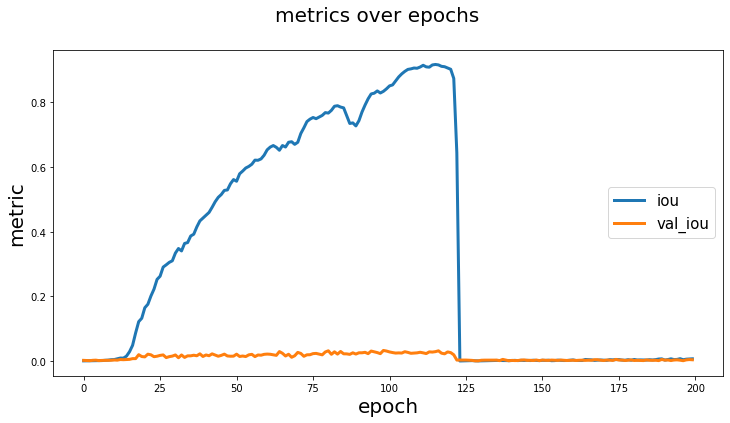

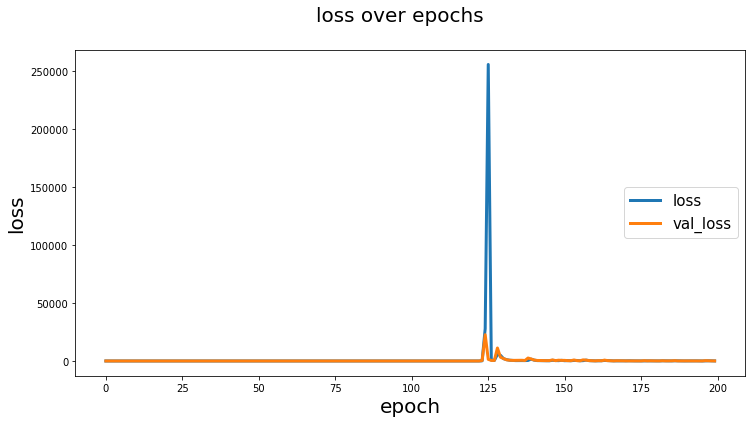

In [16]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [17]:
y_pred = model.predict(X_val)

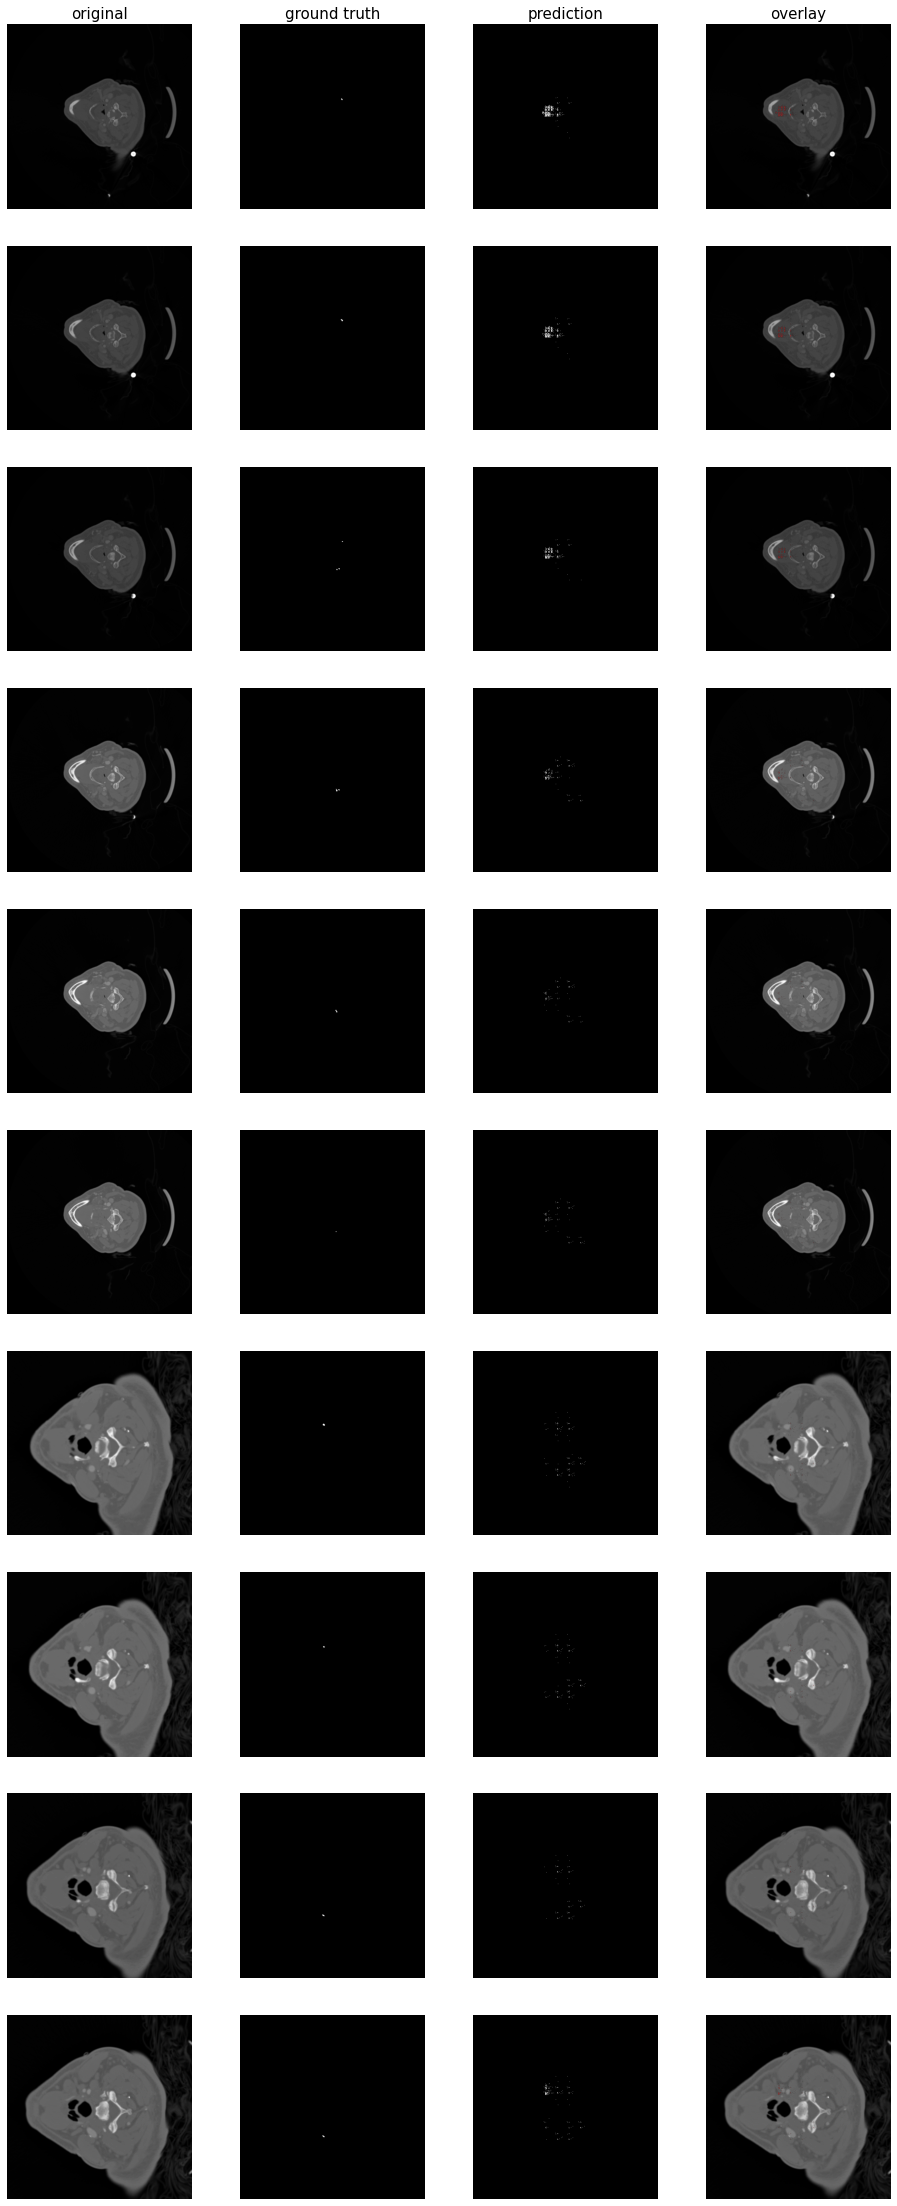

In [18]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [19]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

5/5 [==============================] - 2s 424ms/step - loss: 55.8736 - iou: 0.0040 - iou_thresholded: 0.0040
